In [2]:
import sys
sys.path.append('../')
import atlas

import os
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Exploring the output

This notebook explores some of the output of `ATLAS` and `SYNTHE` that can be parsed directly with `BasicATLAS`. Note that more data are available in the raw output found in the corresponding run directories.

As our testbed, we will calculate a Sun-like atmosphere and its synthetic spectrum using `~/ATLAS_sun_model` as the working directory. First, make sure the folder does not already exist; and if it does, delete it:

In [3]:
rm -rf ~/ATLAS_sun_model

Run both `ATLAS-9` to calculate the structure of the Sun and `SYNTHE` to calculate its synthetic spectrum, as demonstrated the `sun_model.ipynb` tutorial notebook.

***The calculation may take a few hours***

In [4]:
run_dir = os.path.expanduser('~/ATLAS_sun_model')
atlas.atlas(run_dir)
atlas.synthe(run_dir, 200, 2600)

Launcher created
Starting automatic iterations...
15 iterations completed: max[abs(err)] = 0.177 | max[abs(de)] = 47.292
30 iterations completed: max[abs(err)] = 0.162 | max[abs(de)] = 2.576
ATLAS-9 halted
ATLAS requested/received validation for /home/roman/ATLAS_sun_model successful

Final convergence: max[abs(err)] = 0.162 | max[abs(de)] = 2.576
Saved the model in model.dat
Finished running ATLAS-9 in 0:01:48.659446 s
Adapted the ATLAS-9 model to SYNTHE in output_synthe.out
Launcher created for wavelength range (200, 2600), batch 1. Expected number of points: 1538970 (buffer 2010001)
SYNTHE halted
ATLAS requested/received validation for /home/roman/ATLAS_sun_model successful
SYNTHE requested/received validation for /home/roman/ATLAS_sun_model successful
Total data points: 1538970
Saved the spectrum in spectrum.dat
Finished running SYNTHE in 0:38:14.798230 s


## Structure

For a calculated model, the profiles of physical properties throughout the model atmosphere may be parsed with `atlas.read_structure()`:

In [5]:
structure, units = atlas.read_structure(run_dir)

Here, `structure` contains the profiles themselves and `units` the corresponding physical units. Both are dictionaries with identical sets of keys:

In [6]:
structure.keys()

dict_keys(['layer', 'temperature', 'gas_pressure', 'electron_number_density', 'rosseland_opacity', 'radiative_acceleration', 'turbulent_velocity', 'radiative_flux', 'convective_speed', 'speed_of_sound', 'mass_column_density', 'density', 'physical_depth', 'rosseland_optical_depth', 'convective_flux', 'radiation_pressure', 'flux_error', 'flux_error_derivative'])

Each profile is simply a run of the corresponding quantity throughout the atmosphere, starting with the outermost layer going inwards. For example, we can plot the temperature profile as a function of physical depth:

Text(0, 0.5, 'Temperature [K]')

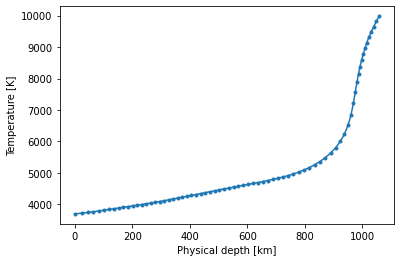

In [9]:
plt.plot(structure['physical_depth'], structure['temperature'], '.-')

# Use the units given in the "units" variable to make meaningful axis labels
plt.xlabel('Physical depth [{}]'.format(units['physical_depth']))
plt.ylabel('Temperature [{}]'.format(units['temperature']))

The points in the plot above represent the layers in the stratification of the atmosphere used by `ATLAS`. A $72$-layer atmosphere is used.

A converged model atmosphere must be in both *hydrostatic equilibrium* (gravitational force on any of the layers is balanced out by outwards pressure so that no mechanical motion occurs) and *energy equilibrium* (a constant energy flux is transmitted through the layers without any energy being created or destroyed). As an exercise, let us check that both hold. The mathematical expression for hydrostatic equilibrium reads:

$$dP=\rho g dh$$

where $dP/dh$ is the pressure gradient with respect to physical (not optical!) depth, $\rho$ is the gas density and $g$ is the gravity which we assume to be constant throughout the atmosphere. In our case, gravity is determined by the parameters of the model. The function `atlas.meta()` can retrieve the initial parameters of a calculated model:

In [10]:
g = 10 ** atlas.meta(run_dir)['logg']       #  Convert to linear scale
print('Gravity: {} m s^-2'.format(g))

Gravity: 27542.28703338169 m s^-2


`structure` contains both gas and radiation pressure throughout the atmosphere. Plot them both out for comparison with respect to temperature:

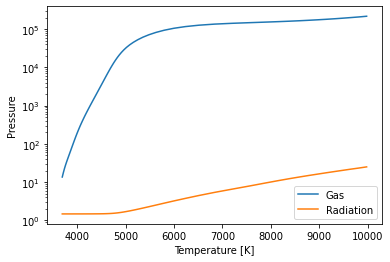

In [11]:
plt.plot(structure['temperature'], structure['gas_pressure'], label = 'Gas')
plt.plot(structure['temperature'], structure['radiation_pressure'], label = 'Radiation')

plt.xlabel('Temperature [{}]'.format(units['temperature']))
plt.ylabel('Pressure'.format(units['gas_pressure']))

plt.yscale('log')
plt.legend()

As is typical for Sun-like stars, gas pressure far dominates over the radiation pressure by many orders of magnitude. We will now verify the hydrostatic equilibrium condition by plotting the left ($dP$) and right ($\rho g dh$) hand sides of the equation on the same set of axes.

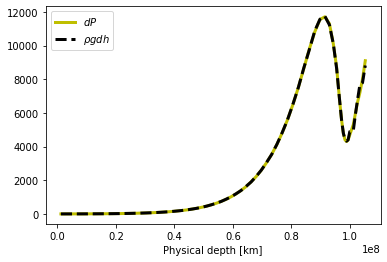

In [12]:
# Get total pressure in each layer (radiation and gas)
P = structure['gas_pressure'] + structure['radiation_pressure']

# Find differences between adjacent layers, i.e. dP
dP = P[1:] - P[:-1]

# For the density, we use the average between each pair of adjacent layers as counterpart values for dP
rho = structure['density']
rho = (rho[1:] + rho[:-1]) / 2.0

# Likewise calculate dh - change in physical depth between layers
h = structure['physical_depth'] * 1e5    # km to cm
dh = h[1:] - h[:-1]
h = (h[1:] + h[:-1]) / 2.0

# Plot both left and right sides on the same set of axes
plt.plot(h, dP, 'y-', label = '$dP$', lw = 3)
plt.plot(h, rho * g * dh, 'k--', label = r'$\rho g dh$', lw = 3)

plt.xlabel('Physical depth [{}]'.format(units['physical_depth']))
plt.legend()

The atmosphere appears to satisfy the condition of hydrostatic equilibrium closely. Let us now verify energy equilibrium. The outgoing energy flux is composed of convective and radiative components. Plot both below for comparison:

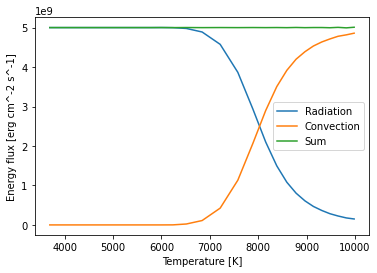

In [11]:
plt.plot(structure['temperature'], structure['radiative_flux'], label = 'Radiation')
plt.plot(structure['temperature'], structure['convective_flux'], label = 'Convection')
plt.plot(structure['temperature'], structure['radiative_flux'] + structure['convective_flux'], label = 'Sum')

plt.xlabel('Temperature [{}]'.format(units['temperature']))
plt.ylabel('Energy flux [{}]'.format(units['radiative_flux']))
plt.legend()

While radiative energy transfer dominates at outer layers (where the atmosphere is sufficiently transparent for radiation to propagate through) and convective transfer dominates in inner layers, the sum of both energy fluxes appears nearly constant throughout the atmosphere, as one expects from the energy equilibrium condition.

The cell below calculates what that constant value is by taking the average across all layers:

In [13]:
mean_flux = np.mean(structure['radiative_flux'] + structure['convective_flux'])
print('Mean flux: {:.5e} {}'.format(mean_flux, units['radiative_flux']))

Mean flux: 5.00109e+09 erg cm^-2 s^-1


The value calculated above - the total outgoing energy flux - is given by the effective temperature of the star, which is also one of the input parameters similar to gravity. The relationship is given by Stefan-Boltzmann law:

$$F_\mathrm{sum}=\frac{4\sigma}{\pi} T^4_\mathrm{eff}$$

where $F_\mathrm{sum}$ is the sum of fluxes above and $\sigma$ is the Stefan-Boltzmann constant. The effective temperature is available in the meta data as before:

In [15]:
teff = atlas.meta(run_dir)['teff']
print('Effective temperature: {} K'.format(teff))

Effective temperature: 5770.0 K


Now calculate the Stefan-Boltzmann prediction for $F_\mathrm{sum}$:

In [16]:
sigma = 5.670374e-5            # Stefan-Boltzmann constant in CGS
Fsum = sigma * teff ** 4.0 / (4 * np.pi)
print('Stefan-Boltzmann flux: {:.5e} {}'.format(Fsum, units['radiative_flux']))

Stefan-Boltzmann flux: 5.00156e+09 erg cm^-2 s^-1


The correspondence between the two values is good but not perfect. The difference is known as the *flux error* which is also provided as a percentage value in `structure`:

Maximum flux error: 0.162%


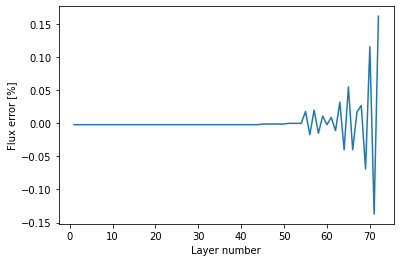

In [24]:
plt.plot(structure['layer'], structure['flux_error'])
plt.xlabel('Layer number')
plt.ylabel('Flux error [%]')

# Also print the maximum error
print('Maximum flux error: {}%'.format(np.max(np.abs(structure['flux_error'])))) # Take absolute value

You may notice that the maximum error matches that reported earlier in the notebook when running `ATLAS`. As a rule of thumb, maximum flux error under 1% indicates good convergence, so the energy equilibrium condition may be considered well-satisfied. In principle, the result may be improved by carrying out more iterations.

Another important feature of the plot above is that the error tends to increase in the inner layers of the atmosphere. This does not necessarily indicate that the outer layers are more "correct". Rather, flux error becomes progressively less informative at shallow depths as the atmosphere is nearly transparent and, whether calculated correctly or not, has very little effect on the overall radiative flux.

To properly evaluate energy equilibrium in outer layers, we must look at the derivative of energy flux rather than the flux itself. The percentage error in the flux derivative is available in the `structure` variable as well:

Maximum flux derivative error: 2.576%


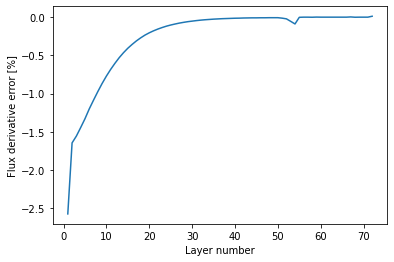

In [26]:
plt.plot(structure['layer'], structure['flux_error_derivative'])
plt.xlabel('Layer number')
plt.ylabel('Flux derivative error [%]')

# Also print the maximum error
print('Maximum flux derivative error: {}%'.format(np.max(np.abs(structure['flux_error_derivative']))))

In general, flux derivative errors under 10% are considered satisfactory as is the case here.

For completeness, let us check that the calculated structure satisfies the relationship between Rosseland optical depth ($\tau_R$) and Rosseland mean opacity ($\kappa_R$):

$$d\tau_R=\kappa_R \rho dh$$

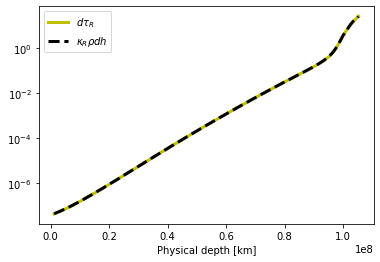

In [27]:
tau_r = structure['rosseland_optical_depth']
kappa_r = structure['rosseland_opacity']

dtau_r = tau_r[1:] - tau_r[:-1]
kappa_r = (kappa_r[1:] + kappa_r[:-1]) / 2.0

plt.plot(h, dtau_r, 'y-', label = r'$d\tau_R$', lw = 3)
plt.plot(h, kappa_r * rho * dh, 'k--', label = r'$\kappa_R \rho dh$', lw = 3)

plt.xlabel('Physical depth [{}]'.format(units['physical_depth']))
plt.legend()
plt.yscale('log')

For a grey atmosphere (i.e. an atmosphere whose opacity is independent of wavelength), temperature has a simple algebraic dependence on optical depth:

$$T=T_\mathrm{eff}\left(\frac{3}{4}\left[\tau + \frac{2}{3} \right] \right)^{1/4}$$

The atmosphere of the Sun is, of course, very far from grey. We can plot both the calculated temperature profile of the Sun and the grey profile above to inspect how important the "coloured" opacity is:

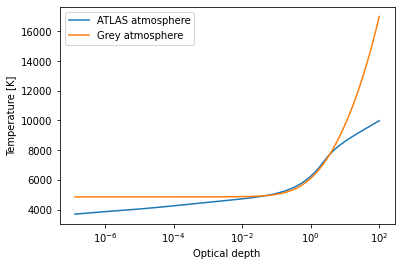

In [34]:
# First plot the calculate temperature/optical depth profile
plt.plot(structure['rosseland_optical_depth'], structure['temperature'], label = 'ATLAS atmosphere')

# Now calculate and plot the grey profile as per the equation above
T_grey = teff * ((3/4) * (structure['rosseland_optical_depth'] + (2/3))) ** (1/4)
plt.plot(structure['rosseland_optical_depth'], T_grey, label = 'Grey atmosphere')

# Label the plot
plt.ylabel('Temperature [{}]'.format(units['temperature']))
plt.xlabel('Optical depth')
plt.legend()

plt.xscale('log')

## Spectrum

Read the synthetic spectrum from a successful `SYNTHE` run with `atlas.read_spectrum()`:

In [35]:
# Bin the spectrum into 1000 uniform wavelength intervals for visualization purposes
spectrum = atlas.read_spectrum(run_dir, num_bins = 1000)

Synthetic spectra have $\mathrm{A}$ as wavelength units and $\mathrm{erg}\ \mathrm{s}^{-1}\ \mathrm{cm}^{-2}\ \mathrm{A}^{-1}\ \mathrm{strad}^{-1}$ as flux units. The `spectrum` dictionary defined above contains both the synthesized flux and its continuum constituent:

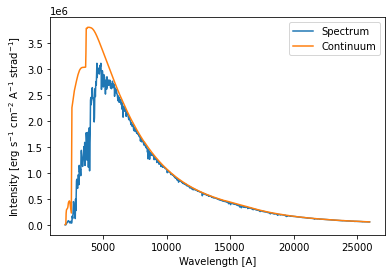

In [36]:
plt.plot(spectrum['wl'], spectrum['flux'], label = 'Spectrum')
plt.plot(spectrum['wl'], spectrum['cont'], label = 'Continuum')

plt.xlabel('Wavelength [A]')
plt.ylabel('Intensity [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$ strad$^{-1}$]')
plt.legend()

The ratio of the two fluxes stored in the `line` key of the dictionary emphasizes line absorption in the atmosphere:

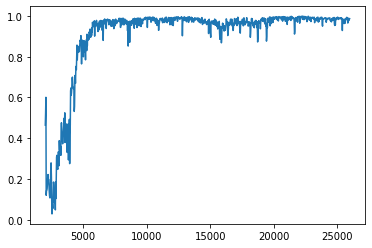

In [37]:
plt.plot(spectrum['wl'], spectrum['line'], label = 'Spectrum')

Now plot the calculated spectrum with the blackbody Planck profile corresponding to the same effective temperature:

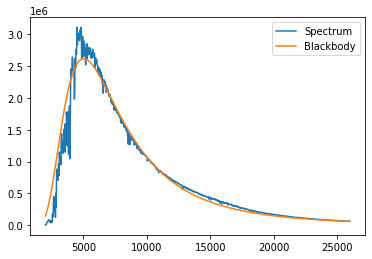

In [38]:
# Planck blackbody profile
def planck(wl, T):
    h = 6.62607015e-34      # Planck constant
    c = 3e8                 # Speed of light
    k = 1.380649e-23        # Boltzmann constant
    wl = wl * 1e-10         # Angstrums to metres
    result = 2.0 * h * c ** 2 / ((wl ** 5) * (np.exp(h * c / (wl * k * T)) - 1.0))

    # Output in CGS
    return result * 1e-7

plt.plot(spectrum['wl'], spectrum['flux'], label = 'Spectrum')
plt.plot(spectrum['wl'], planck(spectrum['wl'], teff), label = 'Blackbody')
plt.legend()